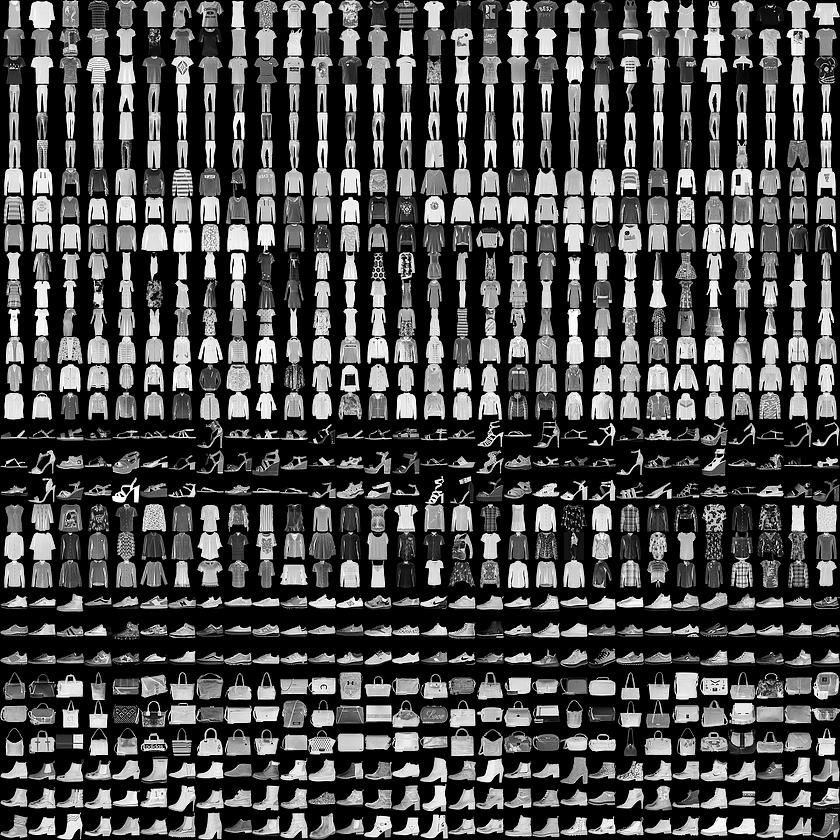

### *Import Library* yang Diperlukan

In [1]:
# Import library
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# Import library yang berfungsi untuk import data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-06139c1a8346>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# Gunakan GPU jika tersedia
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### *Import* dan Proses Data

In [3]:
# Transformasi
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

In [4]:
# Import data dan secara bersamaan terapkan transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.17MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.4MB/s]


In [5]:
# Bagi devtest menjadi dua buah set yang berbeda
randidx = np.random.permutation(10000)   # Permutasi acak dari indeks
devset  = Subset(devtest,randidx[:6000]) # Subset untuk devset
testset = Subset(devtest,randidx[6000:]) # Subset untuk test

In [6]:
# Mengubah set tersebut menjadi Dataloader
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset))
test_loader  = DataLoader(testset, batch_size=len(testset))

In [7]:
# Memeriksa bentuk dataset
print('Data shapes (train/dev/test):')
print( len(trainset) )
print( len(devset) )
print( len(testset) )

# Memeriksa rentang nilai intensitas piksel
print('\nData value range:')
print( (torch.min(trainset.data),torch.max(trainset.data)) )

# Kategori unik
print('\nData categories:')
print( trainset.classes )

Data shapes (train/dev/test):
60000
6000
4000

Data value range:
(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

Data categories:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
# Sepertinya the images masih dalam dimensi yang salah
# The images seharusnya berukuran 1x28x28
# Data yang digunakan juga belum dinormalisasi

# Tapi...
X,y = next(iter(test_loader))

# Coba jalankan kode berikut sekali lagi
print('Data shapes (train/test):')
print( X.data.shape )

# Jangan lupa rentang nilai intensitas piksel
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([4000, 1, 28, 28])

Data value range:
(tensor(-1.), tensor(1.))


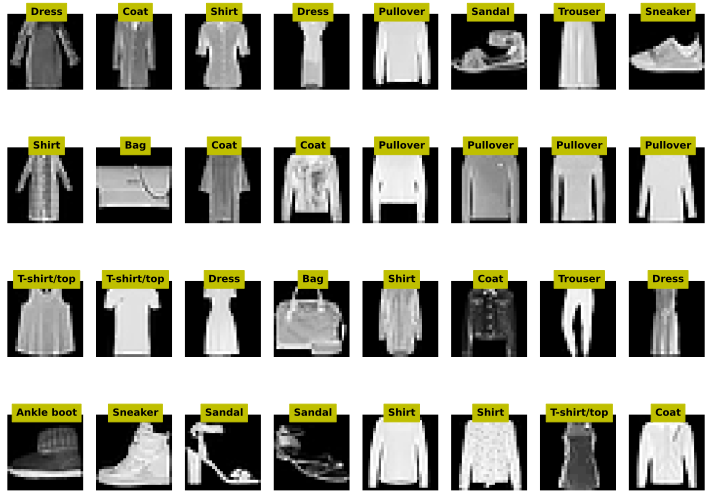

In [10]:
# Periksa beberapa images secara acak

fig,axs = plt.subplots(4,8,figsize=(10,8))

for (i, ax) in enumerate(axs.flatten()):

  # Ekstrak image tersebut
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalisasi

  # Definisikan labelnya
  label = trainset.classes[y[i]]

  # Visualisasi hasil
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

### Membuat Model *Deep Learning*

In [11]:
# Membuat sebuah class untuk model
def makeTheNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # Cetak toggle
      self.print = printtoggle

      ### -------------- Layer Feature Map -------------- ###
      # Layer Convolution Pertama
      self.conv1  = nn.Conv2d(1,16,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(16) # Input jumlah channel dalam layer ini
      # Ukuran output: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # Layer Convolution Kedua
      self.conv2  = nn.Conv2d(16,32,3)
      self.bnorm2 = nn.BatchNorm2d(32) # Input jumlah channel dalam layer ini
      # Ukuran output: (14+2*0-3)/1 + 1 = 12/2 = 6 (/2 b/c maxpool)

      ### -------------- Layer Linear Decision -------------- ###
      self.fc1 = nn.Linear(6*6*32,64)
      self.fc2 = nn.Linear(64,32)
      self.fc3 = nn.Linear(32,10)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # Block Pertama: Convolution -> Maxpool -> Batchnorm -> ReLU
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'Block CPR Pertama: {list(x.shape)}')

      # Block Kedua: Convolution -> Maxpool -> Batchnorm -> ReLU
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Block CPR Kedua: {list(x.shape)}')

      # Reshape untuk layer linear
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # Layer Linear
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training) # training=self.training berarti untuk turn off selama mode evaluasi
      x = self.fc3(x)
      if self.print: print(f'Output Akhir: {list(x.shape)}')

      return x

  # Membuat model instance
  net = cnnnet(printtoggle)

  # Loss function
  lossfunction = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net, lossfunction, optimizer

In [15]:
# Menguji model dengan satu batch
net, lossfunction, optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# Periksa ukuran output
print('\nUkuran output:')
print(yHat.shape)

# # Menghitung loss dari model
loss = lossfunction(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
Block CPR Pertama: [32, 16, 14, 14]
Block CPR Kedua: [32, 32, 6, 6]
Vectorized: [32, 1152]
Output Akhir: [32, 10]

Ukuran output:
torch.Size([32, 10])
 
Loss:
tensor(2.3245, grad_fn=<NllLossBackward0>)


### Membuat Sebuah *Function* yang akan Melatih Model

In [16]:
# Sebuah function yang akan melatih model
def funtion2trainTheModel():

  # Jumlah epochs
  jumlahEpochs = 10

  # Membuat sebuah model baru
  net, lossfunction, optimizer = makeTheNet()

  # Mengirim model ke GPU
  net.to(device)

  # Inisialisasi loss
  trainLoss = torch.zeros(jumlahEpochs)
  devLoss   = torch.zeros(jumlahEpochs)
  trainAcc  = torch.zeros(jumlahEpochs)
  devAcc    = torch.zeros(jumlahEpochs)


  # Membuat loop sebanyak jumlah epochs
  for epochs in range(jumlahEpochs):

    # Membuat loop sebanyak batch training data
    net.train() # Beralih ke train mode
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # Mengirim data ke GPU
      X = X.to(device)
      y = y.to(device)

      # Forward pass dan Loss
      yHat = net(X)
      loss = lossfunction(yHat,y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Loss dan akurasi dari batch ini
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # Akhir dari loop untuk batch

    # Dapatkan rata-rata loss dan akurasi di seluruh batch
    trainLoss[epochs] = np.mean(batchLoss)
    trainAcc[epochs]  = 100*np.mean(batchAcc)


    #### Menguji performance
    net.eval() # Berakhir ke test mode
    X,y = next(iter(dev_loader))

    # Mengirim data ke GPU
    X = X.to(device)
    y = y.to(device)

    # Forward pass dan Loss
    with torch.no_grad():
      yHat = net(X)
      loss = lossfunction(yHat,y)

    # Dapatkan rata-rata loss dan akurasi di seluruh batch
    devLoss[epochs] = loss.item()
    devAcc[epochs]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

  # Epochs berakhir

  # Output dari function
  return trainLoss, devLoss, trainAcc, devAcc,net

## Jalankan Model dan Tampilkan Hasilnya

In [17]:
# Proses ini akan berjalan selama kurang lebih 3 menit,
# dengan 10 epochs pada GPU
trainLoss,devLoss,trainAcc,devAcc,net = funtion2trainTheModel()

In [18]:
## Test set yang sesungguhnya

net.eval() # Beralih ke test mode
X,y = next(iter(test_loader))

# Mengirim data ke GPU
X = X.to(device)
y = y.to(device)

# Forward pass dan Loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfunction(yHat,y)

# Loss dan akurasi dari batch ini
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

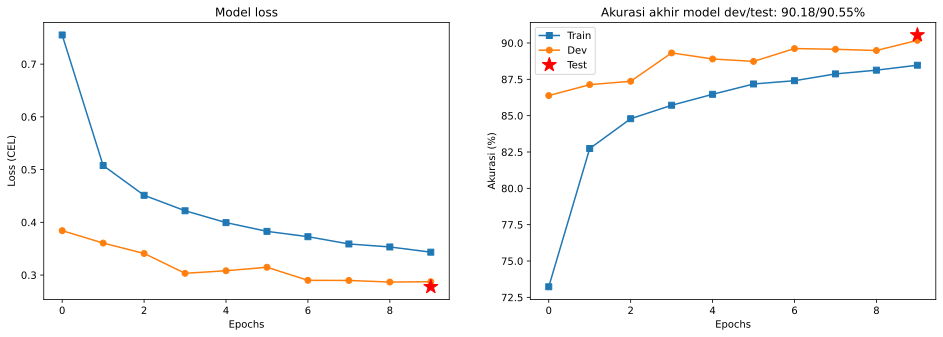

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Akurasi (%)')
ax[1].set_title(f'Akurasi akhir model dev/test: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()